In [ ]:
!pip install openmeteo_requests requests-cache retry-requests tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.5 MB/s eta 0:00:00


In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from tqdm import tqdm
import time

# --- Configuration ---

# A representative list of 51 locations (50 states + D.C.)
# This provides a much better geographical spread for a national average.
# We'll add population data in Step 2 for weighting.
CITIES_BY_STATE = [
    {"name": "Montgomery, AL", "lat": 32.36, "lon": -86.30},
    {"name": "Anchorage, AK", "lat": 61.21, "lon": -149.90},
    {"name": "Phoenix, AZ", "lat": 33.45, "lon": -112.07},
    {"name": "Little Rock, AR", "lat": 34.74, "lon": -92.28},
    {"name": "Los Angeles, CA", "lat": 34.05, "lon": -118.24},
    {"name": "Denver, CO", "lat": 39.74, "lon": -104.99},
    {"name": "Hartford, CT", "lat": 41.76, "lon": -72.68},
    {"name": "Dover, DE", "lat": 39.15, "lon": -75.52},
    {"name": "Washington, D.C.", "lat": 38.90, "lon": -77.03},
    {"name": "Jacksonville, FL", "lat": 30.33, "lon": -81.65}, # More central than Miami
    {"name": "Atlanta, GA", "lat": 33.75, "lon": -84.39},
    {"name": "Honolulu, HI", "lat": 21.30, "lon": -157.85},
    {"name": "Boise, ID", "lat": 43.61, "lon": -116.20},
    {"name": "Chicago, IL", "lat": 41.88, "lon": -87.63},
    {"name": "Indianapolis, IN", "lat": 39.76, "lon": -86.15},
    {"name":"Des Moines, IA", "lat": 41.60, "lon": -93.60},
    {"name": "Wichita, KS", "lat": 37.68, "lon": -97.33},
    {"name": "Louisville, KY", "lat": 38.25, "lon": -85.75},
    {"name": "New Orleans, LA", "lat": 29.95, "lon": -90.07},
    {"name": "Augusta, ME", "lat": 44.31, "lon": -69.77},
    {"name": "Baltimore, MD", "lat": 39.29, "lon": -76.61},
    {"name": "Boston, MA", "lat": 42.36, "lon": -71.06},
    {"name": "Detroit, MI", "lat": 42.33, "lon": -83.04},
    {"name": "Minneapolis, MN", "lat": 44.98, "lon": -93.27},
    {"name": "Jackson, MS", "lat": 32.29, "lon": -90.18},
    {"name": "Kansas City, MO", "lat": 39.10, "lon": -94.58},
    {"name": "Helena, MT", "lat": 46.59, "lon": -112.03},
    {"name": "Omaha, NE", "lat": 41.25, "lon": -95.93},
    {"name": "Las Vegas, NV", "lat": 36.17, "lon": -115.14},
    {"name": "Concord, NH", "lat": 43.20, "lon": -71.53},
    {"name": "Newark, NJ", "lat": 40.73, "lon": -74.17},
    {"name": "Albuquerque, NM", "lat": 35.08, "lon": -106.65},
    {"name": "New York, NY", "lat": 40.71, "lon": -74.01},
    {"name": "Charlotte, NC", "lat": 35.22, "lon": -80.84},
    {"name": "Bismarck, ND", "lat": 46.80, "lon": -100.78},
    {"name": "Columbus, OH", "lat": 39.96, "lon": -82.99},
    {"name": "Oklahoma City, OK", "lat": 35.46, "lon": -97.51},
    {"name": "Portland, OR", "lat": 45.52, "lon": -122.67},
    {"name": "Philadelphia, PA", "lat": 39.95, "lon": -75.16},
    {"name": "Providence, RI", "lat": 41.82, "lon": -71.41},
    {"name": "Columbia, SC", "lat": 34.00, "lon": -81.03},
    {"name": "Sioux Falls, SD", "lat": 43.54, "lon": -96.73},
    {"name": "Nashville, TN", "lat": 36.16, "lon": -86.78},
    {"name": "Houston, TX", "lat": 29.76, "lon": -95.36},
    {"name": "Salt Lake City, UT", "lat": 40.76, "lon": -111.89},
    {"name": "Burlington, VT", "lat": 44.47, "lon": -73.21},
    {"name": "Richmond, VA", "lat": 37.54, "lon": -77.43},
    {"name": "Seattle, WA", "lat": 47.61, "lon": -122.33},
    {"name": "Charleston, WV", "lat": 38.34, "lon": -81.63},
    {"name": "Milwaukee, WI", "lat": 43.03, "lon": -87.90},
    {"name": "Cheyenne, WY", "lat": 41.13, "lon": -104.82},
]


START_DATE = "2020-01-01"
END_DATE = "2025-05-31"
OUTPUT_FILE = "usa_daily_temps_bystate_raw_2020-2025.csv" # Updated filename

def fetch_data_for_city(city, client):
    """
    Fetches historical temperature data for a single city.
    """
    params = {
        "latitude": city["lat"],
        "longitude": city["lon"],
        "start_date": START_DATE,
        "end_date": END_DATE,
        "daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean"],
        "timezone": "auto"  # Automatically adjust for local timezone
    }

    try:
        responses = client.weather_api("https"
                                     "://archive-api.open-meteo.com/v1/archive", params=params)

        # Process the first (and only) location response
        response = responses[0]

        # Process daily data
        daily = response.Daily()

        # --- FIX: Generate the date range correctly ---
        # The original code incorrectly used daily.Time() as if it were an array.
        # The correct method is to generate a date_range from the start, end, and interval.
        daily_data = {
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq='D', # 'D' stands for daily frequency (1 day)
                inclusive="left" # Use "left" as TimeEnd() is exclusive
            )
        }

        # Check if the number of dates matches the number of data points
        if len(daily_data["date"]) != len(daily.Variables(0).ValuesAsNumpy()):
             print(f"Warning: Date range length ({len(daily_data['date'])}) does not match data length ({len(daily.Variables(0).ValuesAsNumpy())}) for {city['name']}.")
             # Truncate data if date range is shorter (e.g., end_date is today)
             data_length = len(daily_data["date"])
             daily_data["t_max_c"] = daily.Variables(0).ValuesAsNumpy()[:data_length]
             daily_data["t_min_c"] = daily.Variables(1).ValuesAsNumpy()[:data_length]
             daily_data["t_mean_c"] = daily.Variables(2).ValuesAsNumpy()[:data_length]
        else:
            daily_data["t_max_c"] = daily.Variables(0).ValuesAsNumpy()
            daily_data["t_min_c"] = daily.Variables(1).ValuesAsNumpy()
            daily_data["t_mean_c"] = daily.Variables(2).ValuesAsNumpy()

        # --- End of Fix ---

        df = pd.DataFrame(data=daily_data)
        df["location"] = city["name"] # Changed "city" to "location"

        return df

    except Exception as e:
        print(f"Error fetching data for {city['name']}: {e}")
        return None

def main():
    """
    Main function to fetch data for all locations and save to CSV.
    """

    print("This script will run in a Colab environment.")
    print("Make sure you have the required libraries installed:")
    print("!pip install openmeteo-requests requests-cache retry-requests pandas tqdm\n")

    # Setup the Open-MSslMeteo API client with cache and retries
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    print(f"Starting data fetch for {len(CITIES_BY_STATE)} locations from {START_DATE} to {END_DATE}...")

    all_location_data = []

    # Use tqdm for a nice progress bar
    for location in tqdm(CITIES_BY_STATE, desc="Fetching location data"):
        location_df = fetch_data_for_city(location, openmeteo)
        if location_df is not None:
            all_location_data.append(location_df)
        time.sleep(3) # Be polite to the API

    if not all_location_data:
        print("No data was fetched. Exiting.")
        return

    # Combine all individual location DataFrames into one
    print("\nCombining all location data into a single DataFrame...")
    final_df = pd.concat(all_location_data, ignore_index=True)

    # Clean up date column (remove timezone info for simplicity in CSV)
    final_df['date'] = final_df['date'].dt.date

    # Save to CSV
    try:
        final_df.to_csv(OUTPUT_FILE, index=False)
        print(f"\nSuccessfully saved all raw daily data to '{OUTPUT_FILE}'")
        print("You can download this file from the Colab file browser.")

        print("\n--- Data Head ---")
        print(final_df.head())
        print("\n--- Data Info ---")
        final_df.info()
        print("\n--- Data Tail (to show different locations) ---")
        print(final_df.tail())

    except Exception as e:
        print(f"Error saving data to CSV: {e}")

# --- Main Execution ---
if __name__ == "__main__":
    # This block will run when you execute the script
    main()

This script will run in a Colab environment.
Make sure you have the required libraries installed:
!pip install openmeteo-requests requests-cache retry-requests pandas tqdm

Starting data fetch for 51 locations from 2020-01-01 to 2025-05-31...


Fetching location data: 100%|██████████| 51/51 [02:41<00:00,  3.17s/it]



Combining all location data into a single DataFrame...

Successfully saved all raw daily data to 'usa_daily_temps_bystate_raw_2020-2025.csv'
You can download this file from the Colab file browser.

--- Data Head ---
         date    t_max_c    t_min_c   t_mean_c        location
0  2020-01-01  13.233001   3.033000   8.514251  Montgomery, AL
1  2020-01-02  20.583000   9.233001  14.835086  Montgomery, AL
2  2020-01-03  20.432999  14.483001  18.239252  Montgomery, AL
3  2020-01-04  14.583000   4.683000  11.962169  Montgomery, AL
4  2020-01-05  11.883000   0.833000   6.124668  Montgomery, AL

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100878 entries, 0 to 100877
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      100878 non-null  object 
 1   t_max_c   100878 non-null  float32
 2   t_min_c   100878 non-null  float32
 3   t_mean_c  100878 non-null  float32
 4   location  100878 non-null  obje

In [ ]:
import pandas as pd

df = pd.read_csv('usa_daily_temps_bystate_raw_2020-2025.csv')

# Check the unique dates in the DataFrame
print("Unique dates in the DataFrame:")
display(df['date'].unique())

# Count entries per location
print("\nNumber of entries per location:")
display(df['location'].value_counts())

Unique dates in the DataFrame:


array(['2020-01-01'], dtype=object)


Number of entries per location:


,count
location,
"Montgomery, AL",1827
"Anchorage, AK",1827
"Phoenix, AZ",1827
"Little Rock, AR",1827
"Los Angeles, CA",1827
"Denver, CO",1827
"Hartford, CT",1827
"Dover, DE",1827
"Washington, D.C.",1827


In [ ]:
!pip install fredapi

In [ ]:
import pandas as pd
import warnings
from fredapi import Fred

# --- Configuration ---

# *** IMPORTANT ***
# Paste your FRED API Key here. Get one for free from:
# https://fred.stlouisfed.org/docs/api/api_key.html
FRED_API_KEY = "82f88c71d5328479903c2b42b2bf87ce"

# Input file from Step 1
INPUT_FILE = "usa_daily_temps_bystate_raw_2020-2025.csv"

# Final output file
OUTPUT_FILE_WEEKLY = "usa_weekly_avg_temps_2020-2025.csv"

# Mapping from our location names to State Abbreviations
# This is needed to match temp data to population data
LOCATION_STATE_MAP = {
    "Montgomery, AL": "AL", "Anchorage, AK": "AK", "Phoenix, AZ": "AZ",
    "Little Rock, AR": "AR", "Los Angeles, CA": "CA", "Denver, CO": "CO",
    "Hartford, CT": "CT", "Dover, DE": "DE", "Washington, D.C.": "DC",
    "Jacksonville, FL": "FL", "Atlanta, GA": "GA", "Honolulu, HI": "HI",
    "Boise, ID": "ID", "Chicago, IL": "IL", "Indianapolis, IN": "IN",
    "Des Moines, IA": "IA", "Wichita, KS": "KS", "Louisville, KY": "KY",
    "New Orleans, LA": "LA", "Augusta, ME": "ME", "Baltimore, MD": "MD",
    "Boston, MA": "MA", "Detroit, MI": "MI", "Minneapolis, MN": "MN",
    "Jackson, MS": "MS", "Kansas City, MO": "MO", "Helena, MT": "MT",
    "Omaha, NE": "NE", "Las Vegas, NV": "NV", "Concord, NH": "NH",
    "Newark, NJ": "NJ", "Albuquerque, NM": "NM", "New York, NY": "NY",
    "Charlotte, NC": "NC", "Bismarck, ND": "ND", "Columbus, OH": "OH",
    "Oklahoma City, OK": "OK", "Portland, OR": "OR", "Philadelphia, PA": "PA",
    "Providence, RI": "RI", "Columbia, SC": "SC", "Sioux Falls, SD": "SD",
    "Nashville, TN": "TN", "Houston, TX": "TX", "Salt Lake City, UT": "UT",
    "Burlington, VT": "VT", "Richmond, VA": "VA", "Seattle, WA": "WA",
    "Charleston, WV": "WV", "Milwaukee, WI": "WI", "Cheyenne, WY": "WY"
}

def fetch_population_data(api_key):
    """
    Fetches annual state population data from FRED.
    """
    if api_key == "PASTE_YOUR_API_KEY_HERE":
        print("Error: Please paste your FRED API key into the FRED_API_KEY variable.")
        return None

    print("Connecting to FRED to fetch population data...")
    try:
        fred = Fred(api_key=api_key)

        # Get all state abbreviations + DC
        state_codes = sorted(list(set(LOCATION_STATE_MAP.values())))

        # FRED series ID for population is "[STATE_CODE]POP" (e.g., NYPOP, CAPOP)
        population_series_ids = [f"{code}POP" for code in state_codes]

        all_pop_data = []
        for series_id in population_series_ids:
            try:
                # Get annual data, ends in 2023 (as of late 2024)
                data = fred.get_series(series_id)
                data = data.to_frame(name='population')
                data['state_abbr'] = series_id.replace("POP", "")
                # Only keep data from 2019 onward to cover our range
                all_pop_data.append(data.loc['2019-01-01':])
            except Exception as e:
                print(f"Warning: Could not fetch {series_id}. Error: {e}")

        if not all_pop_data:
            print("Error: No population data fetched from FRED.")
            return None

        # Combine all states into one DataFrame
        pop_df = pd.concat(all_pop_data)
        pop_df.reset_index(inplace=True)
        pop_df.rename(columns={'index': 'date'}, inplace=True)
        pop_df['date'] = pd.to_datetime(pop_df['date'])

        print("Successfully fetched FRED population data.")
        return pop_df

    except Exception as e:
        print(f"Error connecting to FRED: {e}")
        return None

def process_data(input_file, output_file, api_key):
    """
    Loads temperature data, merges with FRED population data,
    and calculates simple and weighted weekly averages.
    """

    # --- 1. Load Temperature Data ---
    print(f"Loading raw temperature data from '{input_file}'...")
    try:
        df_temp = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"Error: Input file not found at '{input_file}'")
        print("Please make sure the file from Step 1 is in the same directory,")
        print("or update the INPUT_FILE variable to the correct path.")
        return

    df_temp['date'] = pd.to_datetime(df_temp['date'])

    # Map state abbreviation to the temperature data
    df_temp['state_abbr'] = df_temp['location'].map(LOCATION_STATE_MAP)

    # --- 2. Fetch Population Data ---
    df_pop = fetch_population_data(api_key)
    if df_pop is None:
        print("Exiting due to population data fetch failure.")
        return

    # --- 3. Prepare and Merge Data ---
    print("Merging temperature and population data...")

    # We need to make the annual population data daily
    # We'll forward-fill the annual value (e.g., 2020 value applies to all 2020 days)

    # Pivot to have dates as index and states as columns
    df_pop_pivot = df_pop.pivot(index='date', columns='state_abbr', values='population')

    # Reindex to a full daily range and forward-fill (ffill)
    # We start from 2020-01-01 (our temp data start)
    date_range = pd.date_range(start='2020-01-01', end=df_temp['date'].max(), freq='D')
    df_pop_daily = df_pop_pivot.reindex(date_range, method='ffill')

    # Unpivot (melt) the data back to a long format
    df_pop_final = df_pop_daily.melt(
        var_name='state_abbr',
        value_name='population',
        ignore_index=False
    )
    df_pop_final.reset_index(inplace=True)
    df_pop_final.rename(columns={'index': 'date'}, inplace=True)

    # Now we can merge the daily temps with the daily (forward-filled) population
    df = pd.merge(df_temp, df_pop_final, on=['date', 'state_abbr'], how='left')

    # Check for any rows that didn't get population data
    if df['population'].isnull().any():
        print("Warning: Some rows failed to merge with population data. Dropping those rows.")
        print(df[df['population'].isnull()][['date', 'location']].tail())
        df = df.dropna(subset=['population'])

    print("Successfully merged temperature and population data.")

    # --- 4. Daily Average Calculations ---

    # Calculate the weighted temperature component for each row
    df['weighted_temp'] = df['t_mean_c'] * df['population']

    # Group by date to sum up the weighted temps and populations
    print("Calculating daily simple and population-weighted averages...")

    # Group by date to get daily totals
    daily_agg = df.groupby('date').agg(
        weighted_temp_sum=('weighted_temp', 'sum'),
        population_sum=('population', 'sum')
    )

    # Calculate simple (non-weighted) average
    daily_simple_avg = df.groupby('date')['t_mean_c'].mean()
    daily_agg['usa_s_avg_c'] = daily_simple_avg # Add to the agg dataframe

    # Divide the total weighted temp by the total population for that day
    daily_agg['usa_w_avg_c'] = daily_agg['weighted_temp_sum'] / daily_agg['population_sum']

    # Keep only the final average columns
    daily_averages = daily_agg[['usa_s_avg_c', 'usa_w_avg_c']]

    print("\n--- Daily Averages Head ---")
    print(daily_averages.head())

    # --- 5. Weekly Resampling ---

    # Resample the daily averages to weekly averages
    # 'W' means "weekly, ending on Sunday"
    # .mean() calculates the average of the 7 daily values for that week.
    print(f"\nResampling daily data to weekly frequency ('W')...")
    weekly_averages = daily_averages.resample('W').mean()

    # Rename columns for clarity
    weekly_averages.rename(columns={
        'usa_s_avg_c': 'usa_weekly_s_avg_c',
        'usa_w_avg_c': 'usa_weekly_w_avg_c'
    }, inplace=True)

    print("\n--- Weekly Averages Head ---")
    print(weekly_averages.head())

    # --- 6. Save Output ---
    try:
        weekly_averages.to_csv(output_file)
        print(f"\nSuccessfully saved weekly average data to '{output_file}'")
        print("You can now proceed to Step 3: Shock Modeling.")
    except Exception as e:
        print(f"Error saving data to CSV: {e}")

# --- Main Execution ---
if __name__ == "__main__":
    # This block will run when you execute the script
    # Suppress warnings for cleaner output
    warnings.filterwarnings('ignore')

    # Make sure you have the new library installed:
    print("This script requires the 'fredapi' library.")
    print("If you haven't installed it, run: !pip install fredapi\n")

    process_data(INPUT_FILE, OUTPUT_FILE_WEEKLY, FRED_API_KEY)

This script requires the 'fredapi' library.
If you haven't installed it, run: !pip install fredapi

Loading raw temperature data from 'usa_daily_temps_bystate_raw_2020-2025.csv'...
Connecting to FRED to fetch population data...
Successfully fetched FRED population data.
Merging temperature and population data...
Successfully merged temperature and population data.
Calculating daily simple and population-weighted averages...

--- Daily Averages Head ---
            usa_s_avg_c  usa_w_avg_c
date                                
2020-01-01     3.986482     5.879061
2020-01-02     5.453516     7.872324
2020-01-03     7.065404    10.125726
2020-01-04     5.622797     8.322575
2020-01-05     3.472103     5.834128

Resampling daily data to weekly frequency ('W')...

--- Weekly Averages Head ---
            usa_weekly_s_avg_c  usa_weekly_w_avg_c
date                                              
2020-01-05            5.120061            7.606763
2020-01-12            4.330670            7.47565

This script uses 'matplotlib' to generate plots.
If you haven't installed it, run: !pip install matplotlib

Loading weekly average temperature data from 'usa_weekly_avg_temps_2020-2025.csv'...
Data loaded successfully. Index type: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 283 entries, 2020-01-05 to 2025-06-01
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   usa_weekly_s_avg_c  283 non-null    float64
 1   usa_weekly_w_avg_c  283 non-null    float64
dtypes: float64(2)
memory usage: 6.6 KB

Calculating seasonal norms and shocks for:
['usa_weekly_s_avg_c', 'usa_weekly_w_avg_c']

Shock calculations complete.

--- Analysis-Ready Data Head ---
            usa_weekly_s_avg_c  expected_usa_weekly_s_avg_c  \
date                                                          
2020-01-05            5.120061                     2.975684   
2020-01-12            4.330670                     2.

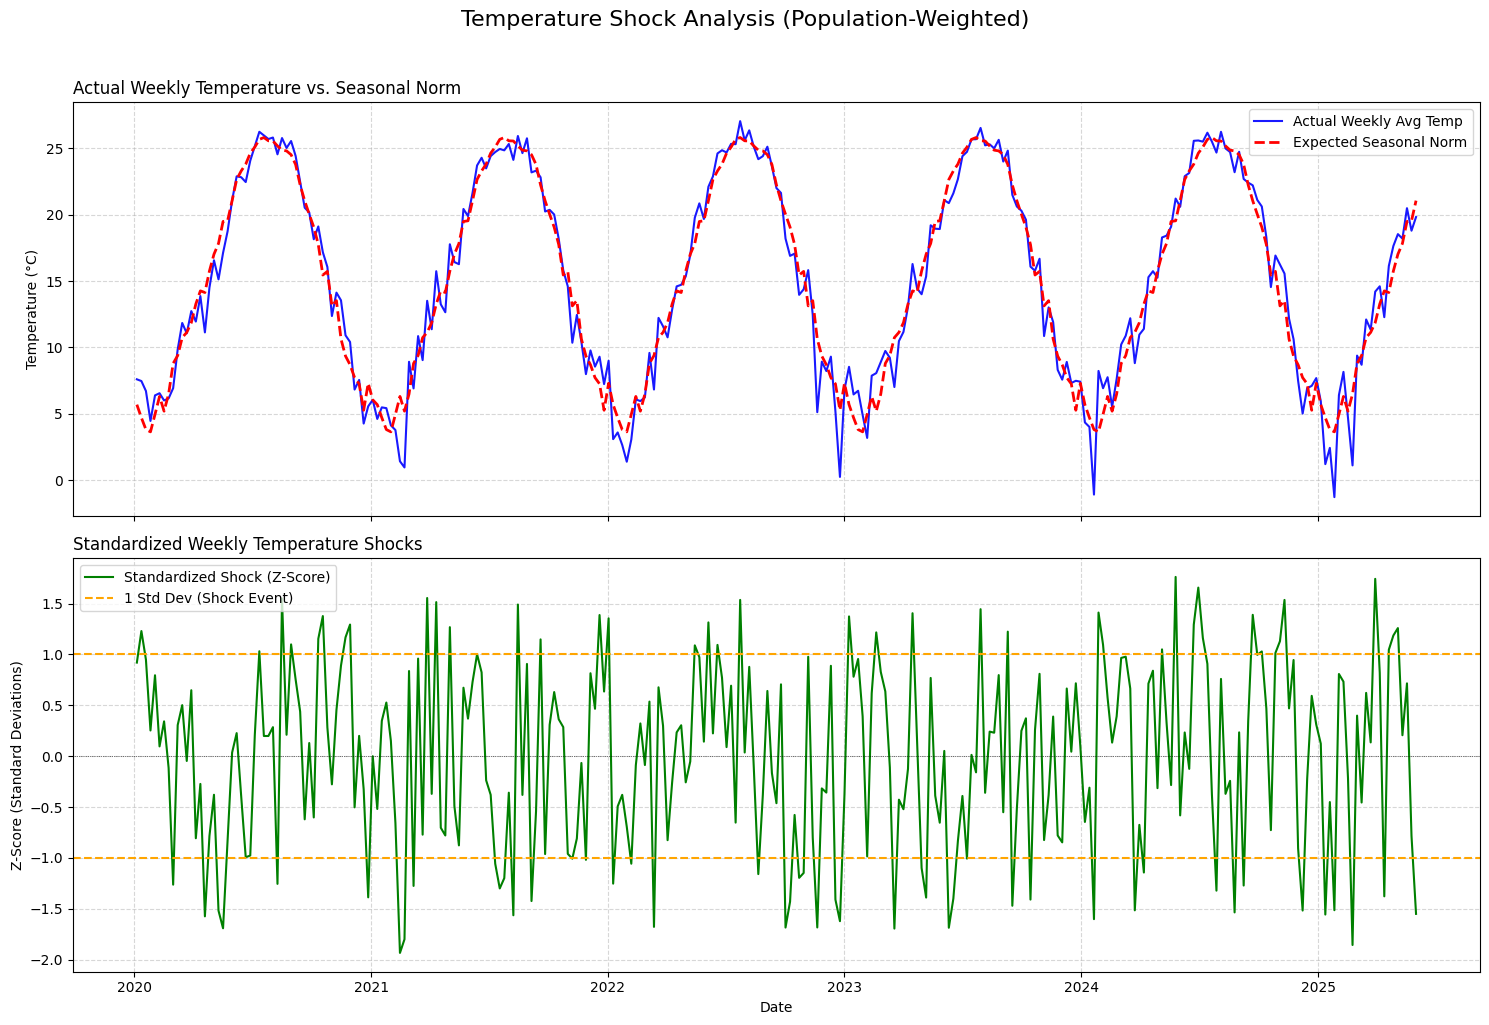

In [5]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt  # Import for plotting

# --- Configuration ---

# Input file from Step 2
INPUT_FILE_WEEKLY = "usa_weekly_avg_temps_2020-2025.csv"

# Final output file, ready for analysis
OUTPUT_FILE_ANALYSIS = "analysis_ready_temp_shocks_2020-2025.csv"

def plot_shock_data(df, temp_col, expected_col, zscore_col):
    """
    Generates a two-part plot to visualize the temperature,
    the seasonal norm, and the resulting shock z-score.
    """
    print(f"\nGenerating plot for {temp_col}...")

    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(15, 10),
        sharex=True  # Both plots share the same x-axis (date)
    )

    # --- Top Plot: Actual Temp vs. Expected Temp ---
    ax1.plot(df.index, df[temp_col], label='Actual Weekly Avg Temp', color='blue', alpha=0.9)
    ax1.plot(df.index, df[expected_col], label='Expected Seasonal Norm', color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Temperature (°C)')
    ax1.set_title('Actual Weekly Temperature vs. Seasonal Norm', loc='left')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)

    # --- Bottom Plot: Standardized Shock (Z-Score) ---
    ax2.plot(df.index, df[zscore_col], label='Standardized Shock (Z-Score)', color='green')
    # Add horizontal lines to show 1, 2, and 3 standard deviations
    ax2.axhline(1, color='orange', linestyle='--', label='1 Std Dev (Shock Event)')
    ax2.axhline(-1, color='orange', linestyle='--')
    ax2.axhline(0, color='black', linestyle=':', linewidth=0.5)

    ax2.set_ylabel('Z-Score (Standard Deviations)')
    ax2.set_title('Standardized Weekly Temperature Shocks', loc='left')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.5)

    fig.suptitle('Temperature Shock Analysis (Population-Weighted)', fontsize=16, y=1.02)
    plt.tight_layout()

    # Save the figure
    plot_filename = 'temp_shock_visualization.png'
    try:
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        print(f"Successfully saved plot to '{plot_filename}'")
    except Exception as e:
        print(f"Error saving plot: {e}")

    # Display the plot
    plt.show()

def calculate_shocks(input_file, output_file):
    """
    Loads weekly average temperature data and calculates
    seasonal norms and standardized shock Z-scores.
    """

    # --- Make sure matplotlib is installed ---
    print("This script uses 'matplotlib' to generate plots.")
    print("If you haven't installed it, run: !pip install matplotlib\n")

    print(f"Loading weekly average temperature data from '{input_file}'...")
    try:
        df = pd.read_csv(input_file, parse_dates=True, index_col='date')
    except FileNotFoundError:
        print(f"Error: Input file not found at '{input_file}'")
        print("Please make sure you have successfully run Step 2.")
        return

    if df.empty:
        print("Error: The input file is empty.")
        return

    print("Data loaded successfully. Index type:", df.index.dtype)
    df.info()

    # --- 1. Identify Week of Year ---
    # We need to know the calendar week (1-53) to group by
    # Using .isocalendar().week is often more stable than .week
    df['week_of_year'] = df.index.isocalendar().week

    # We will perform this calculation for both of our average temp columns
    temp_columns = ['usa_weekly_s_avg_c', 'usa_weekly_w_avg_c']

    print("\nCalculating seasonal norms and shocks for:")
    print(temp_columns)

    for col in temp_columns:

        # --- 2. Calculate Seasonal Norm (Expected Temp) ---
        # For each week of the year, find the average temperature across all years
        # .transform() is powerful: it broadcasts the group mean back to the original index
        expected_temp_col = f'expected_{col}'
        df[expected_temp_col] = df.groupby('week_of_year')[col].transform('mean')

        # --- 3. Calculate Absolute Shock (Deviation) ---
        # This is the simple deviation in degrees C
        shock_col = f'shock_{col}'
        df[shock_col] = df[col] - df[expected_temp_col]

        # --- 4. Standardize the Shock (Z-Score) ---
        # First, find the standard deviation of the shocks *for that week*
        shock_std_col = f'shock_std_{col}'
        df[shock_std_col] = df.groupby('week_of_year')[shock_col].transform('std')

        # Now, calculate the Z-score: (value - mean) / std
        # The mean of the shock *by week* is ~0 by definition, so we just divide
        # by the standard deviation.
        zscore_col = f'zscore_{col}'
        df[zscore_col] = df[shock_col] / df[shock_std_col]

        # Handle potential edge cases where std might be 0 (if only 1 obs)
        # In our >5yr dataset this is unlikely, but good practice.
        df[zscore_col] = df[zscore_col].fillna(0)

    print("\nShock calculations complete.")

    # --- 5. Save Analysis-Ready Data ---

    # Let's clean up the columns, keeping only the most important ones
    # We keep the original temp, the expected temp, the absolute shock, and the z-score

    final_cols = [
        'usa_weekly_s_avg_c',
        'expected_usa_weekly_s_avg_c',
        'shock_usa_weekly_s_avg_c',
        'zscore_usa_weekly_s_avg_c',
        'usa_weekly_w_avg_c',
        'expected_usa_weekly_w_avg_c',
        'shock_usa_weekly_w_avg_c',
        'zscore_usa_weekly_w_avg_c'
    ]

    # Re-order and filter
    analysis_df = df[final_cols]

    print("\n--- Analysis-Ready Data Head ---")
    print(analysis_df.head())

    print("\n--- Analysis-Right Data Info ---")
    analysis_df.info()

    try:
        analysis_df.to_csv(output_file)
        print(f"\nSuccessfully saved analysis-ready data to '{output_file}'")
        print("This file contains your final temperature shock variables.")
    except Exception as e:
        print(f"Error saving data to CSV: {e}")

    # --- 6. Plot the results ---
    # We will plot the population-weighted results as they are
    # more relevant for our econometric analysis.
    plot_shock_data(
        df=analysis_df,
        temp_col='usa_weekly_w_avg_c',
        expected_col='expected_usa_weekly_w_avg_c',
        zscore_col='zscore_usa_weekly_w_avg_c'
    )

# --- Main Execution ---
if __name__ == "__main__":
    warnings.filterwarnings('ignore')

    calculate_shocks(INPUT_FILE_WEEKLY, OUTPUT_FILE_ANALYSIS)

In [4]:
import pandas as pd

# Load the analysis-ready data
df_analysis = pd.read_csv('analysis_ready_temp_shocks_2020-2025.csv', parse_dates=True, index_col='date')

# Define the threshold for a shock (Z-score > 1 or < -1)
shock_threshold = 1

# Filter for shocks in the population-weighted z-score
temp_shocks = df_analysis[
    (df_analysis['zscore_usa_weekly_w_avg_c'] > shock_threshold) |
    (df_analysis['zscore_usa_weekly_w_avg_c'] < -shock_threshold)
]

# Count the number of shocks
num_shocks = len(temp_shocks)

print(f"Total number of temperature shock events (Z-score > {shock_threshold} or < -{shock_threshold}): {num_shocks}")

print("\nDates of these temperature shocks:")
display(temp_shocks[['usa_weekly_w_avg_c', 'expected_usa_weekly_w_avg_c', 'zscore_usa_weekly_w_avg_c']])

Total number of temperature shock events (Z-score > 1 or < -1): 88

Dates of these temperature shocks:


,usa_weekly_w_avg_c,expected_usa_weekly_w_avg_c,zscore_usa_weekly_w_avg_c
date,,,
2020-01-12,7.475659,4.716653,1.229435
2020-03-01,6.940338,8.802042,-1.261993
2020-04-19,11.134412,14.134801,-1.573458
2020-05-10,15.124054,17.822912,-1.517855
2020-05-17,17.110793,19.476590,-1.690495
...,...,...,...
2025-04-13,12.280042,14.258671,-1.376715
2025-04-20,16.128929,14.134801,1.045757
2025-04-27,17.632042,15.748842,1.185871
